In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import time

import os
import sys

# Add the parent directory to sys.path to find the utils package
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.colormaps import b_viridis, b_winter  
from utils.normalization import normalize_range, un_normalize_range
from utils.seed import set_seed

import tqdm

import pypulseq

from cest_mrf.write_scenario import write_yaml_dict
from cest_mrf.dictionary.generation import generate_mrf_cest_dictionary
from cest_mrf.metrics.dot_product import  dot_prod_matching

from configs import ConfigIohexol
from sequences import write_sequence

from dataset import SequentialDataset
from model import Network
import random


set_seed(2024)

Random seed set as 2024


In [2]:
data_f = 'data'
output_f = 'results'

In [3]:
cfg = ConfigIohexol().get_config()

# Define output filenames
yaml_fn = cfg['yaml_fn']
seq_fn = cfg['seq_fn']
dict_fn = cfg['dict_fn']

# Write the .yaml according to the config.py file (inside cest_mrf folder)
write_yaml_dict(cfg)

# Write the seq file for a 2d experiment
# for more info about the seq file, check out the pulseq-cest repository
seq_defs = {}
seq_defs['n_pulses'] = 1  # number of pulses
seq_defs['tp'] = 3  # pulse duration [s]
seq_defs['td'] = 0  # interpulse delay [s]
seq_defs['Trec'] = [1] * 30  # delay before readout [s]
seq_defs['Trec_M0'] = 'NaN'  # delay before m0 readout [s]
seq_defs['M0_offset'] = 'NaN'  # dummy m0 offset [ppm]
seq_defs['DCsat'] = seq_defs['tp'] / (seq_defs['tp'] + seq_defs['td'])  # duty cycle
seq_defs['offsets_ppm'] = [4.3] * 30  # offset vector [ppm]
seq_defs['num_meas'] = len(seq_defs['offsets_ppm'])  # number of repetition
seq_defs['Tsat'] = seq_defs['n_pulses'] * (seq_defs['tp'] + seq_defs['td']) - seq_defs['td']


seq_defs['B0'] = cfg['b0']  # B0 [T]

seqid = os.path.splitext(seq_fn)[1][1:]
seq_defs['seq_id_string'] = seqid  # unique seq id

# we vary B1 for the dictionary generation
seq_defs['B1pa'] = [5, 5, 3, 3.75, 2.5, 1.75, 5.5, 6, 3.75,
                    5.75, 0.25, 3, 6, 4.5, 3.75, 3.5, 3.5, 0, 3.75, 6, 3.75, 4.75, 4.5,
                    4.25, 3.25, 5.25, 5.25, 0.25, 4.5, 5.25]

# Create .seq file
write_sequence(seq_defs, seq_fn)

start = time.perf_counter()
dictionary = generate_mrf_cest_dictionary(seq_fn=seq_fn, param_fn=yaml_fn, dict_fn=dict_fn, num_workers=cfg['num_workers'],
                                axes='xy')  # axes can also be 'z' if no readout is simulated
end = time.perf_counter()
s = (end - start)
print(f"Dictionary simulation and preparation took {s:.03f} s.")


/home/hash/code/cest/nat_prot/molecular-mrf/open-py-cest-mrf/cest_mrf/pypulseq/pypulseq/Sequence/write_seq.py:81: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  arb_grad_mask = grad_lib_values == 'g'
/home/hash/code/cest/nat_prot/molecular-mrf/open-py-cest-mrf/cest_mrf/pypulseq/pypulseq/Sequence/write_seq.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  trap_grad_mask = grad_lib_values == 't'


No MT pools found in param files! specify with "mt_pool" if needed
Found 852720 different parameter combinations.
Dictionary generation started. Please wait...


CPU thread #11 is finished: 100%|██████████| 852720/852720 [00:11<00:00, 72756.96it/s] 


Dictionary simulation took 11.703 s.
Dictionary simulation and preparation took 12.521 s.


In [4]:
if torch.cuda.is_available():
    device = 'cuda'
    print('GPU found and will be used')
else:
    device = 'cpu'
    print('No GPU found. CPU will be used')

GPU found and will be used


In [5]:
# Data organization and normalization
temp_data = sio.loadmat(dict_fn)
min_fs = np.min(temp_data['fs_0'])
min_ksw = np.min(temp_data['ksw_0'].transpose().astype(np.float))
max_fs = np.max(temp_data['fs_0'])
max_ksw = np.max(temp_data['ksw_0'].transpose().astype(np.float))

min_t1w = np.min(temp_data['t1w'])
min_t2w = np.min(temp_data['t2w'].transpose().astype(np.float))
max_t1w = np.max(temp_data['t1w'])
max_t2w = np.max(temp_data['t2w'].transpose().astype(np.float))

min_param_tensor = torch.tensor(np.hstack((0, 0)), requires_grad=False)
max_param_tensor = torch.tensor(np.hstack((max_fs, max_ksw)), requires_grad=False)

# Sequential element normalization (could be t1/t2, but also mt fss and kssw, etc.)
min_water_t1t2_tensor = torch.tensor(np.hstack((min_t1w, min_t2w)), requires_grad=False)
max_water_t1t2_tensor = torch.tensor(np.hstack((max_t1w, max_t2w)), requires_grad=False)

del temp_data, min_fs, min_ksw, max_fs, max_ksw, min_t1w, min_t2w, max_t1w, max_t2w

In [6]:
# Schedule iterations
# number of raw images in the CEST-MRF acquisition schedule
sched_iter = 30

# Training properties
learning_rate = 1e-3
batch_size = 8192
num_epochs = 150
noise_std = 0.0001 # noise level for training 10*log10(1/0.0001) = 40 dB

min_delta = 0.02 # minimum absolute change in the loss function
patience = 300 # number of iterations to wait before early stopping

# Initializing the reconstruction network
reco_net = Network(sched_iter, n_hidden=2, n_neurons=300).to(device)

# print amount of parameters
print('Amount of the model parameters: ', sum(p.numel() for p in reco_net.parameters() if p.requires_grad))

# Setting optimizer
optimizer = torch.optim.Adam(reco_net.parameters(), lr=learning_rate)

# Loading the training dataset
train_dataset = SequentialDataset(dict_fn)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)




Amount of the model parameters:  192302
There are 852720 entries in the training dictionary


In [7]:
# Storing current time
t0 = time.time()

loss_per_epoch = []
loss_per_epoch_test = []

patience_counter = 0
min_loss = 100

reco_net.train()

#   Training loop   #
pbar = tqdm.tqdm(total=num_epochs)
for epoch in range(num_epochs):
    # Cumulative loss
    cum_loss = 0
    counter = np.nan

    for counter, dict_params in enumerate(train_loader, 0):
        cur_fs, cur_ksw, cur_t1w, cur_t2w, cur_norm_sig = dict_params
        
        target = torch.stack((cur_fs, cur_ksw), dim=1)
        input_water_t1t2 = torch.stack((cur_t1w, cur_t2w), dim=1)

        # Normalizing the target and input_water_t1t2
        target = normalize_range(original_array=target, original_min=min_param_tensor,
                                 original_max=max_param_tensor, new_min=0, new_max=1).to(device)

        input_water_t1t2 = normalize_range(original_array=input_water_t1t2, original_min=min_water_t1t2_tensor,
                                           original_max=max_water_t1t2_tensor, new_min=0, new_max=1)

        # Adding noise to the input signals (trajectories) a
        noised_sig = cur_norm_sig + torch.randn(cur_norm_sig.size()) * noise_std

        # noised_sig = noised_sig / torch.linalg.norm(noised_sig, dim=1, ord=2, keepdim=True)

        # adding the water_t1t2 input as two additional elements in the noised_sig vector
        noised_sig = torch.hstack((input_water_t1t2, noised_sig))

        # Forward step
        prediction = reco_net(noised_sig.to(device).float())

        # Batch loss (MSE)
        loss = torch.mean((prediction.float() - target.float()) ** 2)

        # Backward step
        optimizer.zero_grad()
        loss.backward()

        # Optimization step
        optimizer.step()
        
        # Storing Cumulative loss
        cum_loss += loss.item()

    # Average loss for this epoch
    loss_per_epoch.append(cum_loss / (counter + 1))

    pbar.set_description(f'Epoch: {epoch+1}/{num_epochs}, Loss = {loss_per_epoch[-1]}')
    pbar.update(1)

    if (min_loss - loss_per_epoch[-1])/min_loss > min_delta:    
        min_loss = loss_per_epoch[-1]
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter > patience:
        print('Early stopping!')
        break

pbar.close()
print(f"Training took {time.time() - t0:.2f} seconds")

torch.save({
    'model_state_dict': reco_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  #
    'loss_per_epoch': loss_per_epoch,
    'loss_per_epoch_test': loss_per_epoch_test
}, 'checkpoint.pt')
print("The optimized model, optimizer state, and loss history were saved to the file: 'checkpoint.pt'")


Epoch: 150/150, Loss = 0.0002528027883575608: 100%|██████████| 150/150 [04:33<00:00,  1.83s/it] 

Training took 273.83 seconds
The optimized model, optimizer state, and loss history were saved to the file: 'checkpoint.pt'


In [8]:
chkpt = torch.load('checkpoint.pt')
reco_net.load_state_dict(chkpt['model_state_dict'])
optimizer.load_state_dict(chkpt['optimizer_state_dict'])
loss_per_epoch = chkpt['loss_per_epoch']

/tmp/ipykernel_95810/447383321.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chkpt = torch.load('checkpoint.pt')


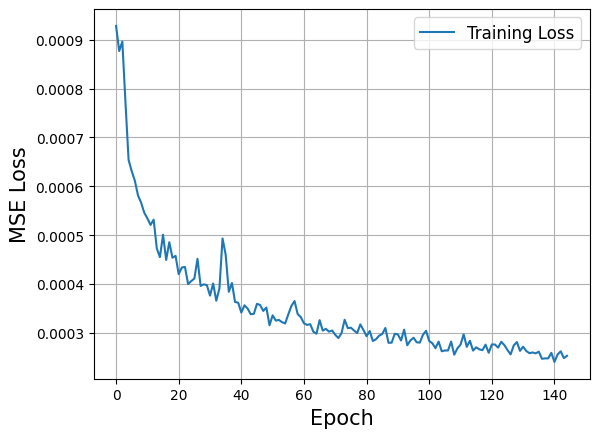

In [9]:
# Plotting training loss
plt.figure()
plt.plot(loss_per_epoch[5:], label='Training Loss')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('MSE Loss', fontsize=15)
plt.legend(fontsize=12)
plt.grid()

In [10]:
acq_data_fn = r'acquired_data_iohexol.mat'
t12_fn = r't1_t2_maps_iohexol.mat'
mask_fn = r'rois_iohexol.mat'

acq_data_fn = os.path.join(data_f, acq_data_fn)
t12_fn = os.path.join(data_f, t12_fn)
mask_fn = os.path.join(data_f, mask_fn)

masks = sio.loadmat(mask_fn)


In [11]:
# Loading the acquired data
acquired_data_orig = sio.loadmat(acq_data_fn)['dataToMatch'].astype(np.float)
acquired_data_orig = np.rot90(acquired_data_orig, axes=(1,2))

[_, c_acq_data, w_acq_data] = np.shape(acquired_data_orig)

mask = np.zeros((c_acq_data, w_acq_data))
for k, v in masks.items():
    if 'ROImask' in k:
        mask += v

# Reshaping the acquired data to the shape expected by the NN (e.g. 30 x ... )
acquired_data = np.reshape(acquired_data_orig, (sched_iter, c_acq_data * w_acq_data), order='F')

# 2-norm normalization of the signals
acquired_data = acquired_data / np.linalg.norm(acquired_data, axis=0, ord=2)

# Transposing for compatibility with the NN - now each row is a trajectory
acquired_data = acquired_data.T

# Converting to tensor
acquired_data_sig = torch.from_numpy(acquired_data).to(device).float()

# Loading the separately acquired water_t1t2-maps
acquired_map_t1w_orig = sio.loadmat(t12_fn)['GT_T1'].astype(np.float) / 1000.0  # (s)
acquired_map_t2w_orig = sio.loadmat(t12_fn)['GT_T2'].astype(np.float) / 1000.0  # (s)

# Reshaping the acquired data to the shape expected by the NN (e.g. 2 x ... )
# And transposing for compatibility with the NN - now each row is a trajectory
acquired_map_t1w = np.reshape(acquired_map_t1w_orig, (1, c_acq_data * w_acq_data), order='F').T
acquired_map_t1w = torch.from_numpy(acquired_map_t1w)

acquired_map_t2w = np.reshape(acquired_map_t2w_orig, (1, c_acq_data * w_acq_data), order='F').T
acquired_map_t2w = torch.from_numpy(acquired_map_t2w)

# Normalizing according to dict water_t1t2 min and max values
input_water_t1t2_acquired = torch.hstack((acquired_map_t1w, acquired_map_t2w))
input_water_t1t2_acquired = normalize_range(original_array=input_water_t1t2_acquired,
                                            original_min=min_water_t1t2_tensor,
                                            original_max=max_water_t1t2_tensor, new_min=0, new_max=1).to(device)

# adding the water_t1t2 input as two additional elements in the noised_sig vector
acquired_data = torch.hstack((input_water_t1t2_acquired, acquired_data_sig)).to(device).float()

print("Acquired data shpare after organization into vectors: " + str(acquired_data.shape))
print("Original Acquired data shape: " + str(acquired_data_orig.shape))
print('Note that the +2 increase is due to the consideration of T1 and T2 values per pixel')

Acquired data shpare after organization into vectors: torch.Size([3600, 32])
Original Acquired data shape: (30, 60, 60)
Note that the +2 increase is due to the consideration of T1 and T2 values per pixel


Text(0.5, 1.0, 'Raw MRF Image #0 out of 30 (a.u)')

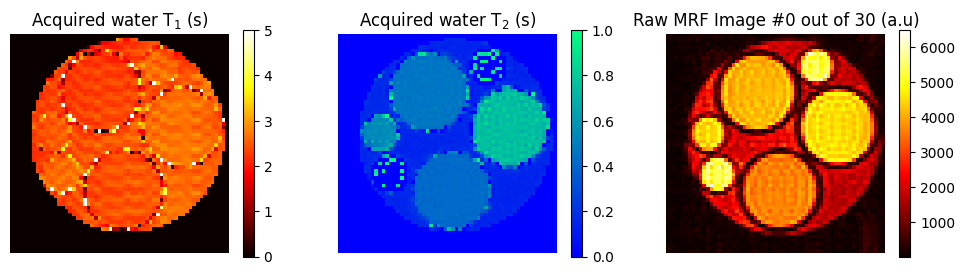

In [12]:
plt.figure(figsize=(12,10))
plt.subplot(331)
plt.imshow(acquired_map_t1w_orig, cmap='hot')
plt.axis("off")
plt.colorbar()
plt.clim([0, 5])
plt.title('Acquired water T$_{1}$ (s)')

plt.subplot(332)
plt.imshow(acquired_map_t2w_orig, cmap='winter')
plt.colorbar()
plt.axis("off")
plt.title('Acquired water T$_{2}$ (s)')
plt.clim([0, 1])

plt.subplot(333)
plt.imshow(acquired_data_orig[0], cmap='hot')
plt.axis("off")
plt.colorbar()
plt.title('Raw MRF Image #0 out of 30 (a.u)')


In [13]:
reco_net.eval()

t0 = time.time()
prediction = reco_net(acquired_data.float())
print(f"Prediction took {time.time() - t0:.5f} seconds")

# Un-normalizing to go back to physical units
prediction = un_normalize_range(prediction, original_min=min_param_tensor.to(device),
                                original_max=max_param_tensor.to(device), new_min=0, new_max=1)


print("Prediction array shape: " + str(prediction.shape))


Prediction took 0.00102 seconds
Prediction array shape: torch.Size([3600, 2])


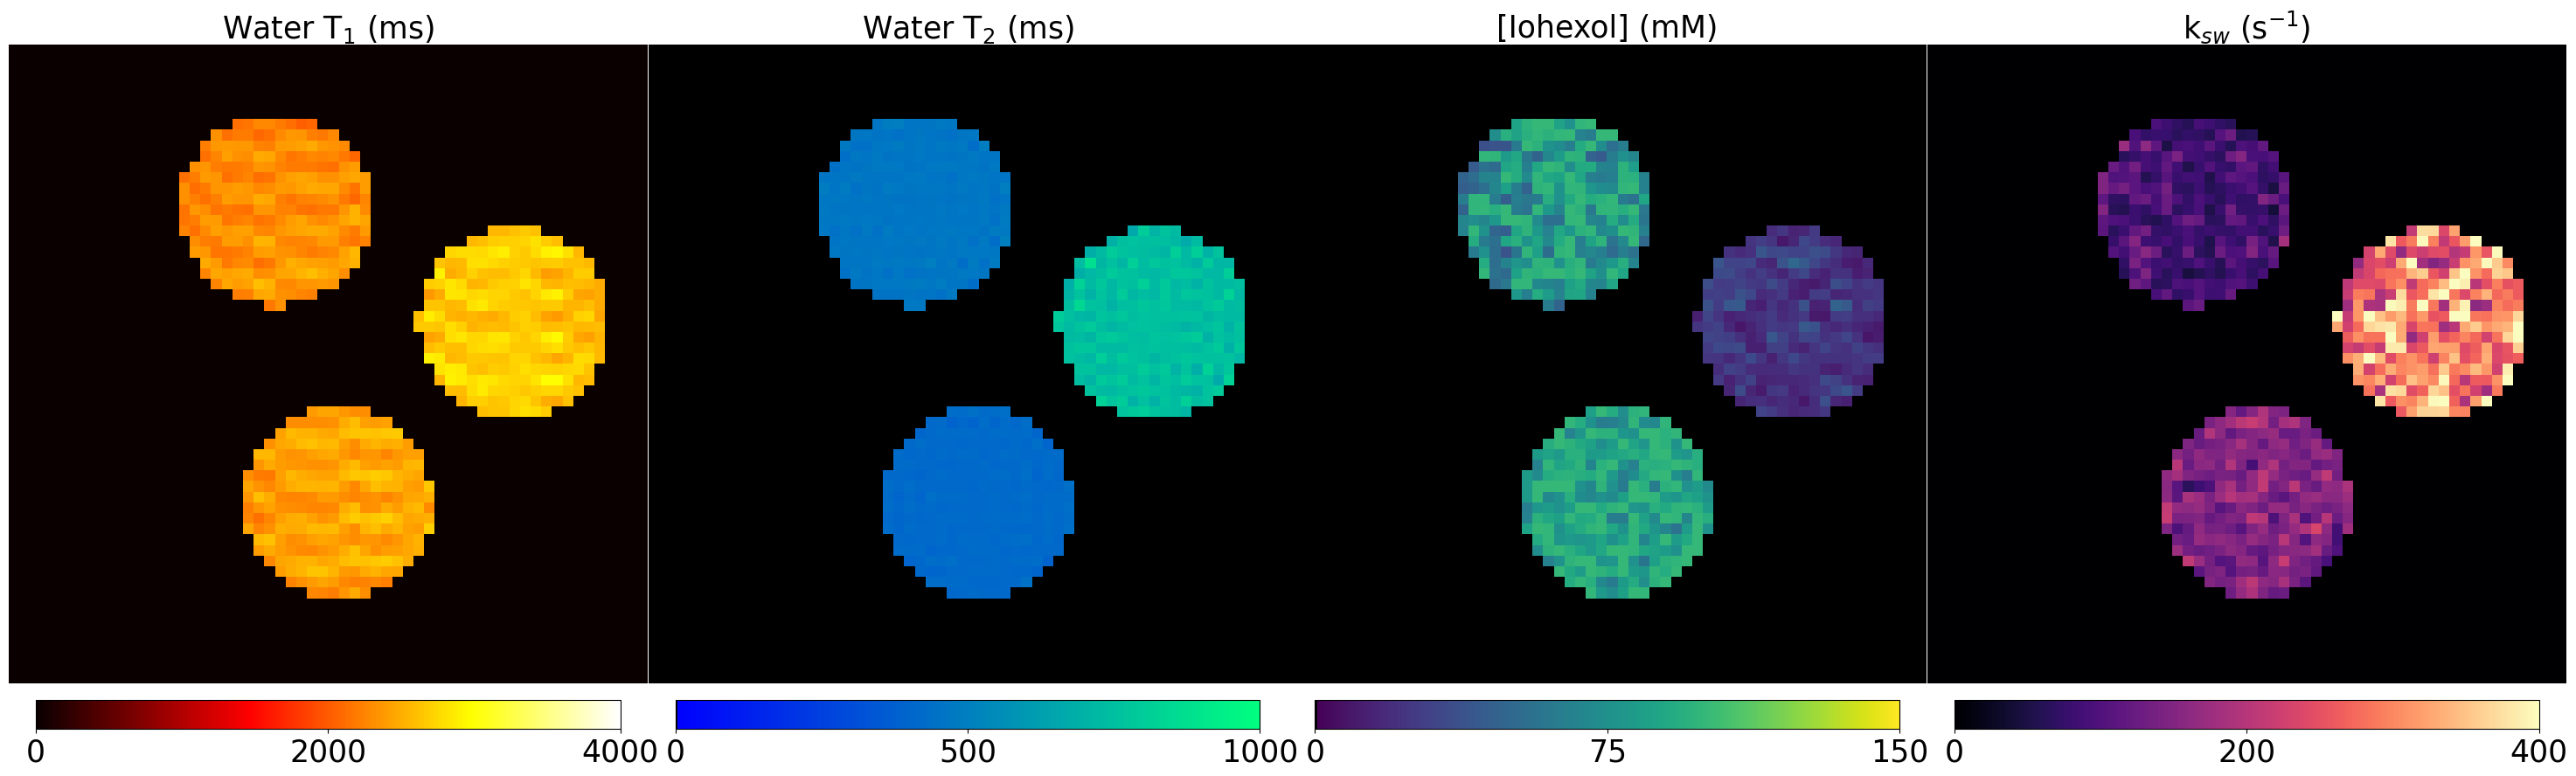

In [14]:
# mask = np.ones((c_acq_data, w_acq_data))
quant_maps = {}

# Reshaping back to the image dimension
quant_maps['fs'] = prediction.cpu().detach().numpy()[:, 0]
quant_maps['fs'] = quant_maps['fs'].T
quant_maps['fs'] = np.reshape(quant_maps['fs'], (c_acq_data, w_acq_data), order='F')

quant_maps['ksw'] = prediction.cpu().detach().numpy()[:, 1]
quant_maps['ksw'] = quant_maps['ksw'].T
quant_maps['ksw'] = np.reshape(quant_maps['ksw'], (c_acq_data, w_acq_data), order='F')

# Converting to ms
quant_maps['t1w'] = acquired_map_t1w_orig * 1000
quant_maps['t2w'] = acquired_map_t2w_orig * 1000

# Saving output maps
os.makedirs(output_f, exist_ok=True)
sio.savemat(os.path.join(output_f, f'nn_reco_maps.mat'), quant_maps)

fig_fn = 'deep_reco.eps' # quantitative maps output filename
fig_fn = os.path.join(output_f, fig_fn)

fig, axes = plt.subplots(1, 4, figsize=(30, 10))

color_maps = ['hot', b_winter, b_viridis, 'magma']
data_keys = ['t1w', 't2w', 'fs', 'ksw']
titles = ['Water T$_{{1}}$ (ms)','Water T$_{{2}}$ (ms)','[Iohexol] (mM)', 'k$_{sw}$ (s$^{-1}$)']
clim_list = [(0, 4000), (0, 1000), (0, 150), (0, 400)]
tick_list = [np.arange(0, 5000, 2000), np.arange(0, 1200, 500),
            np.arange(0, 180, 75), np.arange(0, 600, 200)]

unified_font_size = 25

# Save the plot to a eps file
for ax, color_map, key, title, clim, ticks in zip(axes.flat, color_maps, data_keys, titles, clim_list, tick_list):
    vals = quant_maps[key]

    if key == 'fs':
        vals = vals * 110e3/2

    plot = ax.imshow(vals * mask, cmap=color_map)
    plot.set_clim(*clim)
    ax.set_title(title, fontsize=unified_font_size)
    cb = plt.colorbar(plot, ax=ax, ticks=ticks, orientation='horizontal', fraction=0.036, pad=0.02)
    cb.ax.tick_params(labelsize=unified_font_size)
    ax.set_axis_off()

plt.tight_layout()

plt.subplots_adjust(wspace=0.00091, hspace=0.0001)  # Remove spacing between subplots

plt.savefig(fig_fn, format='eps')

In [15]:
for k, v in masks.items():
    if 'ROImask' in k:
        print(f'Tube {k[-1]}: [Iohexol] {np.mean(quant_maps["fs"][v>0])*110e3/2:.3f} mM +- {np.std(quant_maps["fs"][v>0])*110e3/2:.3f} mM')
        print(f'Tube {k[-1]}: ksw {np.mean(quant_maps["ksw"][v>0]):.3f} Hz +- {np.std(quant_maps["ksw"][v>0]):.3f} Hz')
        print('\n')


Tube 1: [Iohexol] 78.840 mM +- 17.902 mM
Tube 1: ksw 92.061 Hz +- 25.960 Hz


Tube 2: [Iohexol] 23.234 mM +- 7.876 mM
Tube 2: ksw 294.848 Hz +- 66.039 Hz


Tube 3: [Iohexol] 87.616 mM +- 11.655 mM
Tube 3: ksw 150.603 Hz +- 28.188 Hz


